WEEK 1 PROBLEMS. For your own good, it would be helpful to review
the EASY problems at the end of Chapters 1, 2 and 3. The answers are in the
solutions guide.

In [1]:
%pprint # turn on/off pprint

import os

import arviz as az
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import vmap

import numpyro.distributions as dist

import reth2


if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")

Pretty printing has been turned OFF


I0000 00:00:1702426002.400130     336 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
import importlib
importlib.reload(reth2)



<module 'reth2' from '/home/nbooks/stats-rethinking2/reth2.py'>

In [3]:
import numpyro

numpyro.set_platform('gpu')

In [4]:
p_grid = reth2.grid_gen(1000)

def compute_posterior(prior_fn, N, W):
    prior = reth2.standardize(prior_fn(p_grid))
    likelihood = reth2.dbinom(p_grid, N, W)
    posterior = reth2.standardize(likelihood * prior)
    
    plt.subplots(figsize=(12, 2))
    
    plt.subplot(162)
    plt.plot(p_grid, prior)
    
    plt.subplot(164)
    plt.plot(p_grid, likelihood)
    
    plt.subplot(166)
    plt.plot(p_grid, posterior)
    plt.show()
    return posterior

1. Suppose the globe tossing data (Chapter 2) had turned out to be 4 water
and 11 land. Construct the posterior distribution, using grid approximation.
Use the same flat prior as in the book.

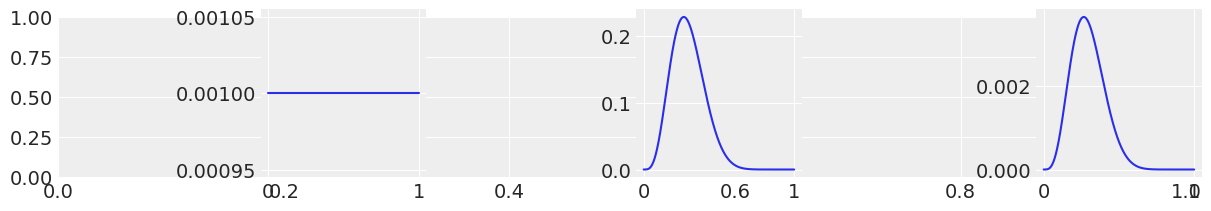

In [5]:
# prio ~ Unif(0, 1)
_ = compute_posterior(lambda p_grid: jnp.repeat(1, len(p_grid)), 4 + 11, 4)

2. Now suppose the data are 4 water and 2 land. Compute the posterior
again, but this time use a prior that is zero below p = 0.5 and a constant
above p = 0.5. This corresponds to prior information that a majority of the
Earth’s surface is water.

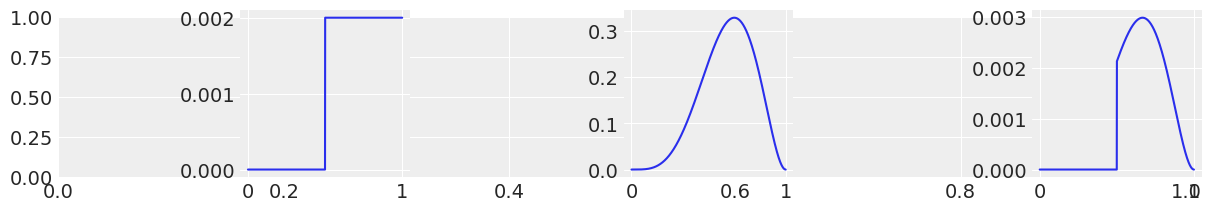

In [6]:
# uniform prior from [0.5, 1]
_ = compute_posterior(lambda p_grid: jnp.where(p_grid < 0.5, 0, 1), 4 + 2, 4)

3. For the posterior distribution from 2, compute 89% percentile and HPDI
intervals. Compare the widths of these intervals. Which is wider? Why? If
you had only the information in the interval, what might you misunderstand
about the shape of the posterior distribution?

HDPI(0.890000) : [0.374374 0.881882]
PI(89) : [0.352352 0.866867]


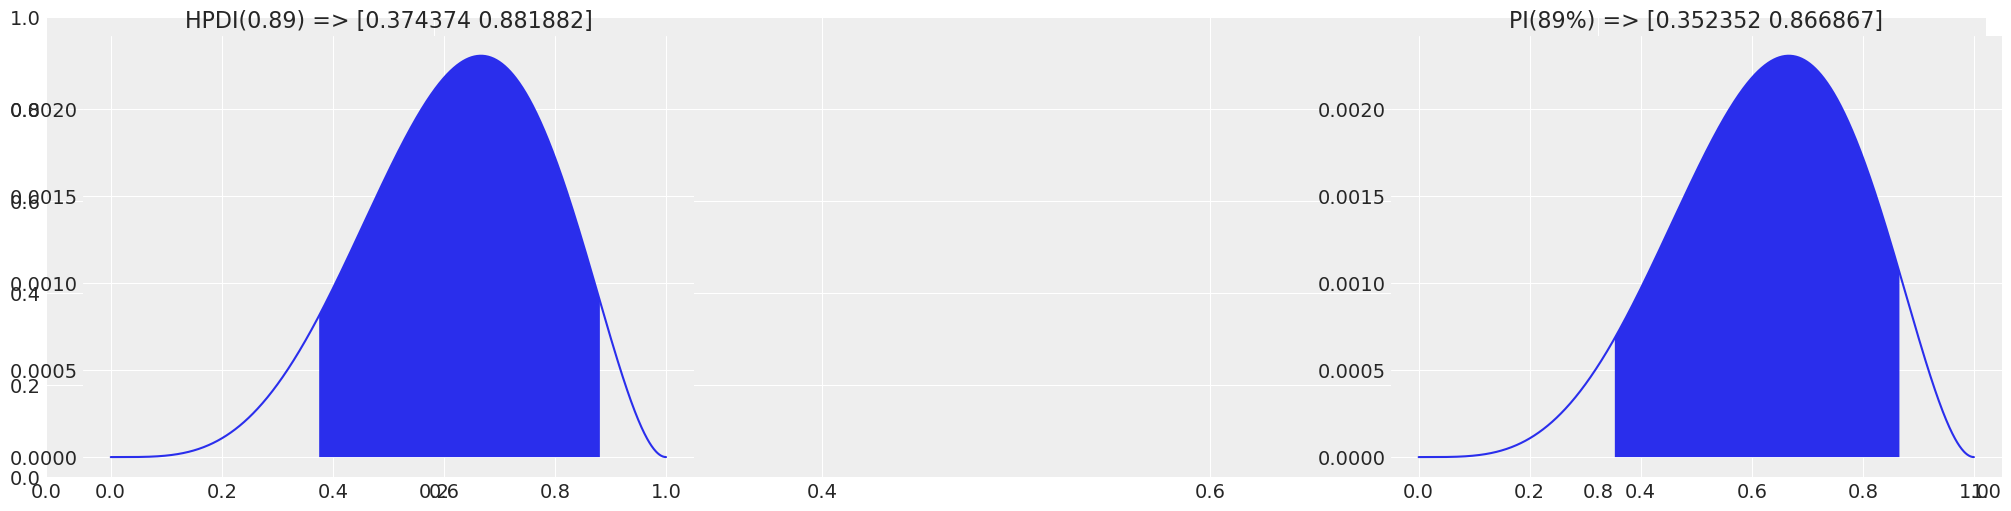

In [7]:
p_grid = reth2.grid_gen(1000)
prior = reth2.standardize(reth2.unif_prior(len(p_grid)))
likelihood = reth2.dbinom(p_grid, 4+2, 4)
posterior = reth2.standardize(likelihood * prior)

samples = reth2.samples_grid(p_grid, posterior, (10000,))
plt.subplots(figsize=(20, 5))

lo, hi = reth2.HPDI(samples, 0.89)
reth2.fill_interval(p_grid, posterior, (lo, hi), "HPDI(0.89) => [%f %f]" % (lo, hi), subplot=131)

lo, hi = reth2.PI(samples, 89)
reth2.fill_interval(p_grid, posterior, (lo, hi), "PI(89%%) => [%f %f]" % (lo, hi), subplot=133)

4. OPTIONAL CHALLENGE. Suppose there is bias in sampling so that Land
is more likely than Water to be recorded. Specifically, assume that 1-in-5
(20%) of Water samples are accidentally recorded instead as ”Land”. First,
write a generative simulation of this sampling process. Assuming the true
proportion of Water is 0.70, what proportion does your simulation tend to
produce instead? Second, using a simulated sample of 20 tosses, compute
the unbiased posterior distribution of the true proportion of water.

In [8]:
# 2 steps, sample true water
gen_N = 1000
true_W = reth2.rbinom(0.7, 20, (gen_N,))
print("mean(true_W) : %f, first 10: %s" % (jnp.mean(true_W/20), true_W[0:10]))
# then, from true sample sample biassed prob
biass_W = reth2.rbinom(0.8, true_W, (gen_N,))[0]
print("mean(biass_W): %f, first 10: %s" % (jnp.mean(biass_W/20), biass_W[0:10]))

# 1 step, sample direct biass prob
biass_W1 = reth2.rbinom(0.7*0.8, 20, (gen_N,))
print("mean(biass_W1): %f, first 10: %s" % (jnp.mean(biass_W1/20), biass_W1[0:10]))


mean(true_W) : 0.696900, first 10: [14 10 15 14 14 15 14 16 12 13]
mean(biass_W): 0.558000, first 10: [12  7 15 12 13 14 11 16  7 12]
mean(biass_W1): 0.555150, first 10: [14  9 10 10 12 11 12 12  9 10]


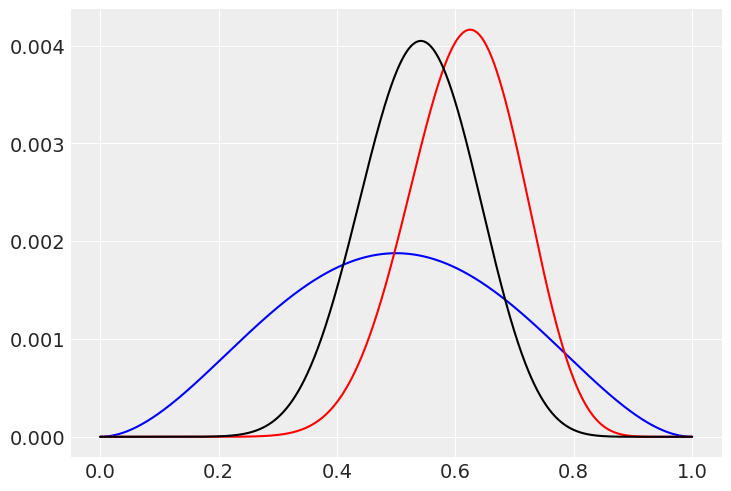

In [9]:
p_grid = reth2.grid_gen(1000)
#prior = reth2.standardize(reth2.unif_prior(len(p_grid)))
prior = reth2.standardize(reth2.dbeta(p_grid, 1+2, 1+2))
plt.plot(p_grid, prior, "b-")

true_posterior = reth2.standardize(prior * reth2.dbinom(p_grid, 20, int(jnp.mean(true_W))))
plt.plot(p_grid, true_posterior, "r-")

biass_posterior = reth2.standardize(prior * reth2.dbinom(p_grid, 20, int(jnp.mean(biass_W))))
plt.plot(p_grid, biass_posterior, "k-")